## Convert SageMaker Built-in Object Detection model

## setup

In [1]:
%matplotlib inline

In [2]:
!pip install opencv-python
!pip install gluoncv

     |████████████████████████████████| 1.3 MB 21.9 MB/s            


In [3]:
from matplotlib import pyplot as plt
from gluoncv.utils import download, viz
import numpy as np
import mxnet as mx
import json
import boto3
import cv2
import os

## Download the trained model artifact 

In [119]:
#JOB_ID='ground-truthod-demo-colleague-vgg16-512-2021-10-30-09-44-32'
JOB_ID='smartsolution-demo-vgg16-512-2022-03-13-06-13-42'
#JOB_ID='smartsolution-demo-resnet-500-512-2022-03-13-06-56-55'

In [120]:
sagemaker_client =  boto3.client('sagemaker',region_name='us-east-1')
MODEL_ARTIFACT = sagemaker_client.describe_training_job(TrainingJobName=JOB_ID)['ModelArtifacts']['S3ModelArtifacts']
MODEL_ARTIFACT

's3://object-detection-gt-lalteng/colleague/trainingjob/colleague-augmented-manifest-output/smartsolution-demo-vgg16-512-2022-03-13-06-13-42/output/model.tar.gz'

In [121]:
def make_tmp_folder(folder_name):
    try:
        os.makedirs(folder_name)
    except OSError as e:
        print("{} folder already exists".format(folder_name))

In [122]:
TMP_FOLDER = 'trained-model'
!rm -rf $TMP_FOLDER
make_tmp_folder(TMP_FOLDER)

!aws s3 cp $MODEL_ARTIFACT $TMP_FOLDER/.

download: s3://object-detection-gt-lalteng/colleague/trainingjob/colleague-augmented-manifest-output/smartsolution-demo-vgg16-512-2022-03-13-06-13-42/output/model.tar.gz to trained-model/model.tar.gz


In [123]:
!tar -xvzf $TMP_FOLDER/model.tar.gz -C $TMP_FOLDER/

hyperparams.json
model_algo_1-0000.params
model_algo_1-symbol.json


## Convert the training model to a deployable model

In [124]:
%%sh
cd ~/SageMaker
rm -rf mxnet-ssd
git clone https://github.com/chenjunweii/mxnet-ssd.git

Cloning into 'mxnet-ssd'...


In [125]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py -h

usage: deploy.py [-h] [--network NETWORK] [--epoch EPOCH] [--prefix PREFIX]
                 [--data-shape DATA_SHAPE] [--num-class NUM_CLASSES]
                 [--nms NMS_THRESH] [--no-force] [--topk NMS_TOPK]

Convert a trained model to deploy model

optional arguments:
  -h, --help            show this help message and exit
  --network NETWORK     which network to use
  --epoch EPOCH         epoch of trained model
  --prefix PREFIX       trained model prefix
  --data-shape DATA_SHAPE
                        data shape
  --num-class NUM_CLASSES
                        number of classes
  --nms NMS_THRESH      non-maximum suppression threshold, default 0.5
  --no-force            dont force non-maximum suppression on different class
  --topk NMS_TOPK       apply nms only to top k detections based on scores.


In [126]:
!cat $TMP_FOLDER/hyperparams.json

{"base_network": "vgg-16", "use_pretrained_model": "1", "num_classes": "12", "mini_batch_size": "8", "epochs": "500", "learning_rate": "0.001", "lr_scheduler_step": "", "lr_scheduler_factor": "0.1", "optimizer": "sgd", "momentum": "0.9", "weight_decay": "0.0005", "overlap_threshold": "0.5", "nms_threshold": "0.45", "num_training_samples": "92", "image_shape": "512", "_tuning_objective_metric": "", "_kvstore": "device", "kv_store": "device", "_num_kv_servers": "auto", "label_width": "350", "freeze_layer_pattern": "", "nms_topk": "400", "early_stopping": "False", "early_stopping_min_epochs": "10", "early_stopping_patience": "5", "early_stopping_tolerance": "0.0", "_begin_epoch": "0"}

In [127]:
!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py --network vgg16_reduced --num-class 12 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/model_algo_1
#!python /home/ec2-user/SageMaker/mxnet-ssd/deploy.py --network resnet50 --num-class 12 --nms .45 --data-shape 512 --prefix $TMP_FOLDER/model_algo_1

out :  <Symbol detection>
[07:42:27] src/nnvm/legacy_json_util.cc:209: Loading symbol saved by previous version v1.4.1. Attempting to upgrade...
[07:42:27] src/nnvm/legacy_json_util.cc:217: Symbol successfully upgraded!
Saved model: trained-model/deploy_model_algo_1-0000.params
Saved symbol: trained-model/deploy_model_algo_1-symbol.json


In [128]:
!ls -alh $TMP_FOLDER

total 289M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Mar 13 07:42 .
drwxrwxr-x 7 ec2-user ec2-user 4.0K Mar 13 07:42 ..
-rw-rw-r-- 1 ec2-user ec2-user  99M Mar 13 07:42 deploy_model_algo_1-0000.params
-rw-rw-r-- 1 ec2-user ec2-user  43K Mar 13 07:42 deploy_model_algo_1-symbol.json
-rw-r--r-- 1 ec2-user ec2-user  690 Mar 13 06:45 hyperparams.json
-rw-r--r-- 1 ec2-user ec2-user  99M Mar 13 06:45 model_algo_1-0000.params
-rw-r--r-- 1 ec2-user ec2-user  44K Mar 13 06:45 model_algo_1-symbol.json
-rw-rw-r-- 1 ec2-user ec2-user  92M Mar 13 06:45 model.tar.gz


## Doing inference with the model on local host

In [102]:
def get_ctx():
    try:
        gpus = mx.test_utils.list_gpus()
        if len(gpus) > 0:
            ctx = []
            for gpu in gpus:
                ctx.append(mx.gpu(gpu))
        else:
            ctx = [mx.cpu()]
    except:
        ctx = [mx.cpu()]
    return ctx

ctx = get_ctx()[0]
ctx

cpu(0)

In [103]:
SHAPE = 512
input_shapes=[('data', (1, 3, SHAPE, SHAPE))]
confidence_threshold = 0.3
#CLASSES = ['Changty','Sky','Roger','Jimmy','Kfira','Rachael','Rinns','Tclan']
CLASSES = ['sky','tclan','william','micheal','rachael','director','hugo','yugiohx','ty','rinns','sandrawu','lalteng']

## Loading the model

In [104]:
%%time

param_path=os.path.join(TMP_FOLDER, 'deploy_model_algo_1')
print("param_path: {}".format(param_path))
sym, arg_params, aux_params = mx.model.load_checkpoint(param_path, 0)
mod = mx.mod.Module(symbol=sym, label_names=[], context=ctx)
mod.bind(for_training=False, data_shapes=input_shapes)
mod.set_params(arg_params, aux_params)

param_path: trained-model/deploy_model_algo_1
CPU times: user 173 ms, sys: 104 ms, total: 277 ms
Wall time: 201 ms


In [105]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def predict_from_file(filepath, reshape=(SHAPE, SHAPE)):
    # Switch RGB to BGR format (which ImageNet networks take)
    img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    if img is None:
        return []

     # Resize image to fit network input
    img = cv2.resize(img, reshape)
    
    org_image = img.copy()
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
 
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    return prob, org_image

In [106]:
def infer(image_path, threshold=confidence_threshold):
    results, org_image = predict_from_file(image_path)
    image_name = image_path.split("/")[-1]
    
    filtered_result = results[results[:, 0] != -1]
    filtered_result = filtered_result[filtered_result[:, 1] >=threshold]
    
    return filtered_result, org_image

## Test inference on single image 

In [115]:
%%time

#test_image = 'test/14465735511528.jpg'
test_image = 'test/IMG_0645.jpg'
#test_image = 'test/IMG_2573.jpg'
#test_image = 'test/IMG_4794.jpg'
#test_image = 'test/line_637535308359381.jpg'
#test_image = 'test/IMG_7155.jpg'
#test_image = 'test/62.png'
#test_image = 'test/IMG_6989.JPG'
results, org_image = infer(test_image)
print(results)  #[label_id, confidence_score, xmin, ymin, xmax, ymax]

[[5.         0.3923212  0.5569656  0.3634497  0.69490874 0.5343896 ]]
CPU times: user 870 ms, sys: 3.95 ms, total: 874 ms
Wall time: 872 ms


In [116]:
img = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)

height = img.shape[0]
width = img.shape[1]

In [117]:
results[:, (2, 4)] *= width
results[:, (3, 5)] *= height

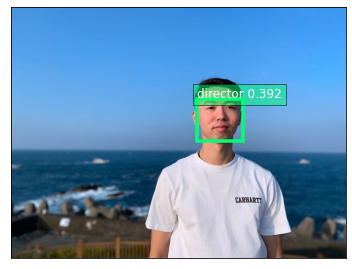

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6, 6), dpi=72)
axis=axes

#ax = viz.plot_bbox(org_image, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
ax = viz.plot_bbox(img, results[:,-4:], results[:,1], results[:,0],thresh=0.1, class_names=CLASSES, ax=axis)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)